* [x] Aplicar filtro passa faixa 3 ou 4 vezes
* [ ] Usar psd welch para setar os segundos do janelamento.
* [ ] O psd retorna uma matriz e nela a gente olha quais são as colunas correspondentes a cada frequência
* [ ] Printa valores para cada um baseado na média das frequências (média de alpha, média beta...)

<ipython-input-27-d967f34e1795>:65: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  raw.plot_psd()


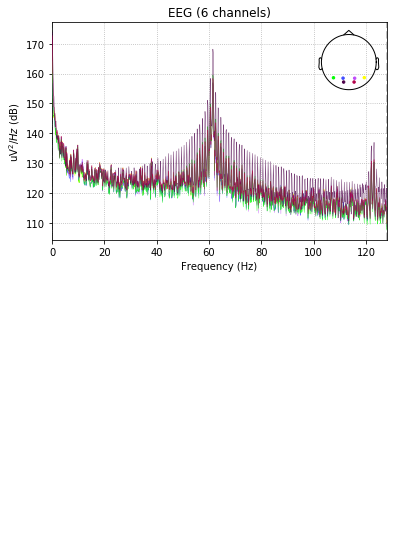

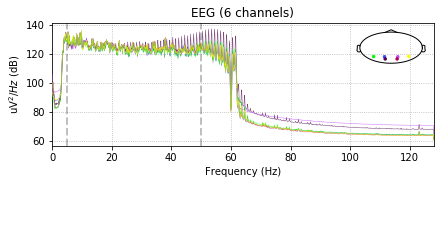

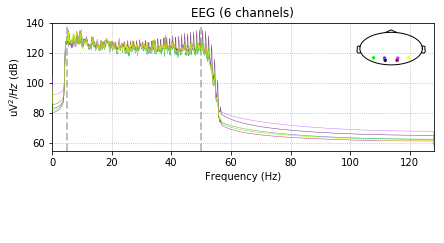


Effective window size : 1.000 (s)


AttributeError: 'numpy.ndarray' object has no attribute 'plot_psd'

In [27]:
%matplotlib inline

import matplotlib.pyplot as plt
import mne
import numpy as np
from copy import deepcopy
from mne.time_frequency import psd_welch as pw

def load_data(file):
    with open(file, 'r') as f:
        data = f.readlines()
    
    compactData = []
    for i in range(len(data)):
        if i >= 6:
            compactData.append(data[i])

    return compactData

def convert(data):
    temp = []
    line = data.split(',')

    for e in range(len(line)):
        if e > 0 and e <= 6:
            temp.append(float(line[e]))
    
    return temp

def separate_data(data):
    index = []
    temp = []
    count = 0

    for e in range(len(data)):
        idx = data[e].split(',')[0]
        if int(idx) == 255 and count == 255:
            index.extend(temp)
            temp = []
            count = 0
        elif int(idx) == 255 and count < 255:
            temp = []
            count = 0
        else:
            temp.append(convert(data[e]))
            count += 1
    
    return index
    
data = load_data('dataset_alpha/RAW_00.txt')
newData = separate_data(data)

def plot_graph(data):
    newData = np.asarray(data)
    newData = newData.T
    ch_names = ['po3', 'po4', 'p8', 'o1', 'o2', 'p7']
    ch_types = ['eeg'] * 6

    info = mne.create_info(ch_names=ch_names, sfreq=256, ch_types=ch_types)
    raw = mne.io.RawArray(newData, info, verbose=False)
    
    montage = mne.channels.read_montage('standard_1020')
    raw.set_montage(montage)
    
    raw.plot_psd()
    return raw

raw = plot_graph(newData)

def sem_nome_again(data, sec):
    data = np.asarray(data)
    data = data[sec*256:(sec+1)*256]
    newData = data.T
    ch_names = ['po3', 'po4', 'p8', 'o1', 'o2', 'p7']
    ch_types = ['eeg'] * 6

    info = mne.create_info(ch_names=ch_names, sfreq=256, ch_types=ch_types, verbose=False)
    raw = mne.io.RawArray(newData, info, verbose=False)
    montage = mne.channels.read_montage('standard_1020')
    raw.set_montage(montage)

    raw.plot_psd()


def apply_notch(raw):
    newRaw = deepcopy(raw)
    newRaw.notch_filter(np.arange(60, 121, 60), fir_design='firwin')
    newRaw.filter(5., 50., fir_design='firwin')
    newRaw.plot_psd(area_mode='range', verbose=False)
    print()
    
apply_notch(raw)


def apply_bandpass(raw):
    newRaw = deepcopy(raw)
    
    for i in range(0, 9):
        newRaw.filter(l_freq=5., h_freq=50.)

    newRaw.plot_psd(area_mode='range', verbose=False)
    
    print()
    return(newRaw)
    
# apply_bandpass(raw)

def plot_time_frequency(raw, i, f):
    newRaw = (apply_bandpass(raw))
    psds, freqs = pw(newRaw, 5., 50., i, f)
#     psds.plot_psd(area_mode='range', verbose=False)
    
plot_time_frequency(raw, 1, 5)
plot_time_frequency(raw, 20, 30)
plot_time_frequency(raw, 45, 60)
plot_time_frequency(raw, 200, 300)
plot_time_frequency(raw, 500, 630)